In [ ]:
!pip install stellargraph

In [2]:
import os 
import pandas as pd
from stellargraph import StellarGraph 

Mounted at /content/drive


In [3]:
DATA_PATH=os.path.join(os.getcwd(),'DATA/')
SAVE_PATH=os.path.join(os.getcwd(),'saved_model/')
Result_PATH=os.path.join(os.getcwd(),'Result/')

In [3]:
edges_data=pd.read_csv(DATA_PATH+'sample.csv')
node_feature=pd.read_csv(DATA_PATH+'sample_feature.csv')
#node_feature=node_feature.drop_duplicates(subset=['index'])
node_features = node_feature.set_index(keys=['index'], inplace=False, drop=True)

In [4]:
node_features.head()

,1,2,3,4,5,6,7,8,9,10,...,290,291,292,293,294,295,296,297,298,299
index,,,,,,,,,,,,,,,,,,,,,
5887,-0.168308,0.453490,-0.095535,0.290504,-0.894610,0.103735,-0.280093,0.074014,0.503019,0.367744,...,-0.163552,-0.086980,-0.145552,0.070703,0.141626,0.001629,-0.096676,-0.052995,-0.112178,-0.090999
3426,2.397051,0.090396,1.236613,0.839081,0.093752,0.323479,-0.483196,-0.176435,-0.552185,0.748059,...,0.584843,0.119463,-0.409786,0.380476,-0.362136,0.192507,0.413073,-0.362811,-0.028254,0.358826
6340,0.844389,2.615271,0.093406,-1.072956,-0.955502,0.727380,-0.141938,-0.092633,0.751066,-1.077170,...,0.114912,-0.324140,-0.153945,0.141717,0.199205,-0.725853,-0.691025,0.233834,0.390434,-0.268641
7031,-0.560994,0.060390,-0.311671,0.110356,0.077707,0.342163,-0.432374,0.023661,0.243273,-0.051051,...,0.007316,0.084201,0.145957,0.006628,-0.108482,-0.102031,0.008283,-0.010563,0.212869,0.000766
7994,2.597059,3.824801,1.423339,1.348240,-2.891339,-0.556217,0.250086,-0.015109,1.021333,0.098333,...,-0.350584,-1.176642,1.377007,-1.279261,1.606988,-0.253019,0.147770,1.038439,0.548416,-1.134808


In [8]:
edges_data=edges_data.drop_duplicates()
edges_data.head()

,target,source
0,2,3
1,3,4
2,4,5
3,5,6
4,6,7


In [9]:
sample = StellarGraph({"feature": node_features}, {"edge": edges_data})

In [10]:
print(sample.info())

StellarGraph: Undirected multigraph
 Nodes: 8472, Edges: 267926

 Node types:
  feature: [8472]
    Features: float32 vector, length 299
    Edge types: feature-edge->feature

 Edge types:
    feature-edge->feature: [267926]
        Weights: all 1 (default)
        Features: none


In [11]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import convert_to_tensor
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [78]:
G=sample
sg.random.set_seed(1161)

In [79]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 26792 positive and 26792 negative edges. **


In [80]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 24113 positive and 24113 negative edges. **


In [81]:
epochs = 200

In [82]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [83]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [101]:
gcn = GCN(
    layer_sizes=[128, 64], 
    activations=["relu", "relu"], 
    generator=train_gen,
    dropout=0.3,
    kernel_regularizer=keras.regularizers.l2(5e-4)
)

In [102]:
x_inp, x_out = gcn.in_out_tensors()

In [103]:
prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)

In [104]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [105]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    # not just "acc" due to https://github.com/tensorflow/tensorflow/issues/41361
    metrics=["binary_accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [106]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 57ms/step - loss: 0.7507 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 0.7509
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 0.7507
	binary_accuracy: 0.5000


In [107]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/200
1/1 - 1s - loss: 0.7521 - binary_accuracy: 0.5000 - val_loss: 0.7194 - val_binary_accuracy: 0.5000 - 904ms/epoch - 904ms/step
Epoch 2/200
1/1 - 0s - loss: 0.7454 - binary_accuracy: 0.5000 - val_loss: 0.6486 - val_binary_accuracy: 0.5046 - 87ms/epoch - 87ms/step
Epoch 3/200
1/1 - 0s - loss: 0.6579 - binary_accuracy: 0.5010 - val_loss: 0.6385 - val_binary_accuracy: 0.5523 - 87ms/epoch - 87ms/step
Epoch 4/200
1/1 - 0s - loss: 0.6397 - binary_accuracy: 0.5283 - val_loss: 0.6296 - val_binary_accuracy: 0.5969 - 92ms/epoch - 92ms/step
Epoch 5/200
1/1 - 0s - loss: 0.6345 - binary_accuracy: 0.5682 - val_loss: 0.6037 - val_binary_accuracy: 0.6140 - 84ms/epoch - 84ms/step
Epoch 6/200
1/1 - 0s - loss: 0.6058 - binary_accuracy: 0.5954 - val_loss: 0.5825 - val_binary_accuracy: 0.6153 - 91ms/epoch - 91ms/step
Epoch 7/200
1/1 - 0s - loss: 0.5860 - binary_accuracy: 0.6054 - val_loss: 0.5778 - val_binary_accuracy: 0.6144 - 88ms/epoch - 88ms/step
Epoch 8/200
1/1 - 0s - loss: 0.5825 - binary_a

In [108]:
model.save(SAVE_PATH+'gcn.model')

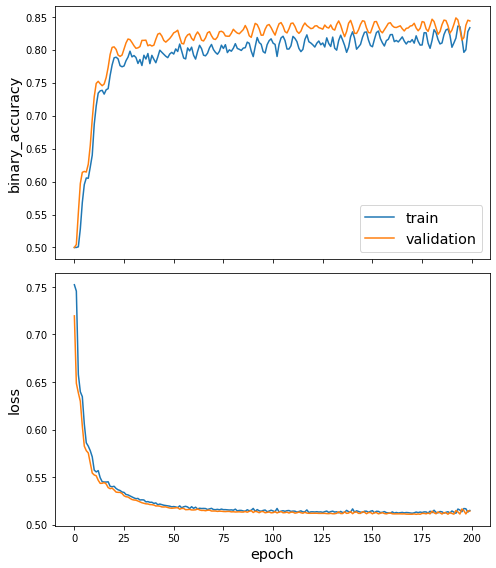

In [110]:
import matplotlib.pyplot as plt

fig=sg.utils.plot_history(history,return_figure=True)
fig.savefig(Result_PATH+'gcn_128_64')

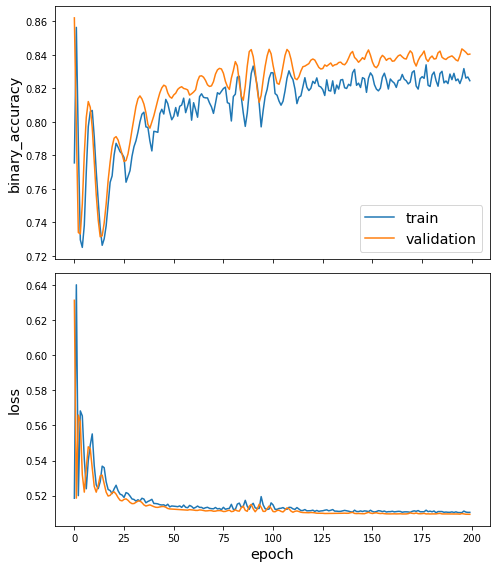

In [70]:
sg.utils.plot_history(history)

In [71]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 61ms/step - loss: 0.5093 - binary_accuracy: 0.8404

Train Set Metrics of the trained model:
	loss: 0.5088
	binary_accuracy: 0.8368

Test Set Metrics of the trained model:
	loss: 0.5093
	binary_accuracy: 0.8404
